##### Imports

In [13]:
# Parameters
top = 250  # default value

In [14]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [15]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.feature_selection \
        import mutual_info_regression
        
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [16]:
## Top 250 dataset

DATA_STORE = Path(f'/home/sayem/Desktop/Project/data/{top}_dataset.h5')

lock_path = "/tmp/assets_h5_file.lock"  # Choose a path for the lock file

from filelock import FileLock

with FileLock(lock_path):
    with pd.HDFStore(DATA_STORE) as store:
        result = store['/data/YEAR_20220906_20230811']

In [17]:
result.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59607 entries, ('AA', Timestamp('2022-09-06 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Columns: 598 entries, FEATURE_open to FEATURE_alpha_101
dtypes: float32(360), float64(31), int32(198), int8(9)
memory usage: 141.7+ MB


In [18]:
result

FEATURE_open  FEATURE_high  FEATURE_low  FEATURE_close  \
ticker date                                                                 
AA     2022-09-06     49.534199     50.391998    47.329800      47.788700   
       2022-09-07     46.900902     47.948299    46.003201      47.539299   
       2022-09-08     47.858501     48.816101    47.030602      48.736301   
       2022-09-09     50.272400     52.935600    50.142700      52.486801   
       2022-09-12     53.264801     53.653801    51.429401      52.207500   
...                         ...           ...          ...            ...   
ZTS    2023-08-07    180.190002    181.880005   180.029999     180.690002   
       2023-08-08    182.149994    190.539993   177.250000     189.300003   
       2023-08-09    189.940002    190.949997   186.964996     189.350006   
       2023-08-10    190.000000    191.824997   187.729996     189.100006   
       2023-08-11    188.479996    191.600006   188.179993     190.830002   

                   FEATURE_volume  FEATURE_market_cap  FEATURE_sector  \
ticker date                                                             
AA     2022-09-06    6.818136e+06        5.703249e+09             4.0   
       2022-09-07    5.256114e+06        5.703249e+09             4.0   
       2022-09-08    5.277750e+06        5.703249e+09             4.0   
       2022-09-09    7.287978e+06        5.703249e+09             4.0   
       2022-09-12    5.296627e+06        5.703249e+09             4.0   
...                           ...                 ...             ...   
ZTS    2023-08-07    1.941699e+06        8.818486e+10             2.0   
       2023-08-08    4.117986e+06        8.818486e+10             2.0   
       2023-08-09    2.270030e+06        8.818486e+10             2.0   
       2023-08-10    2.348639e+06        8.818486e+10             2.0   
       2023-08-11    1.742931e+06        8.818486e+10             2.0   

                   FEATURE_ret_frac_order  FEATURE_ret_01d  FEATURE_ret_02d  \
ticker date                                                                   
AA     2022-09-06                6.346544        -0.027208        -0.003534   
       2022-09-07                6.518137        -0.005219        -0.032285   
       2022-09-08                7.983007         0.025179         0.019829   
       2022-09-09               11.608492         0.076955         0.104072   
       2022-09-12               10.432384        -0.005321         0.071224   
...                                   ...              ...              ...   
ZTS    2023-08-07               16.669207         0.011532        -0.001050   
       2023-08-08               24.922548         0.047651         0.059732   
       2023-08-09               21.726665         0.000264         0.047927   
       2023-08-10               20.455498        -0.001320        -0.001057   
       2023-08-11               21.730034         0.009149         0.007816   

                   FEATURE_ret_03d  FEATURE_ret_04d  FEATURE_ret_05d  \
ticker date                                                            
AA     2022-09-06        -0.031730        -0.056704        -0.136757   
       2022-09-07        -0.008735        -0.036783        -0.061627   
       2022-09-08        -0.007919         0.016225        -0.012530   
       2022-09-09         0.098310         0.068427         0.094428   
       2022-09-12         0.098197         0.092465         0.062742   
...                            ...              ...              ...   
ZTS    2023-08-07        -0.007198        -0.025982        -0.039343   
       2023-08-08         0.046550         0.040110         0.020430   
       2023-08-09         0.060012         0.046827         0.040385   
       2023-08-10         0.046544         0.058613         0.045444   
       2023-08-11         0.008082         0.056118         0.068298   

                   FEATURE_ret_10d  FEATURE_ret_21d  FEATURE_ret_42d  \
ticker date                   

In [19]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from utils import optimize_dataframe
from numba import jit

@jit(nopython=True)
def compute_correlation(data1, data2):
    n = len(data1)
    mean_x = np.mean(data1)
    mean_y = np.mean(data2)
    
    num = np.sum((data1 - mean_x) * (data2 - mean_y))
    den = np.sqrt(np.sum((data1 - mean_x)**2) * np.sum((data2 - mean_y)**2))
    
    if den == 0:
        return np.nan
    else:
        return num / den

def calculate_ic(dataframe, target_column, target_ranked, n_jobs=-1):
    # Exclude the target column from the feature list
    features = [col for col in dataframe.columns.tolist() if col != target_column]
    correlations = Parallel(n_jobs=n_jobs)(
        delayed(compute_correlation)(dataframe[column].values, target_ranked) for column in features
    )
    ic_original = pd.Series(dict(zip(features, correlations))).sort_values(ascending=False)
    return ic_original

def calculate_ic_batched(dataframe, target_column, batch_size=50, corr_threshold=0.5, n_jobs=-1):
    df_ranked = dataframe.rank()
    target_ranked = df_ranked[target_column].values
    columns = [col for col in dataframe.columns.tolist() if col != target_column]
    

    ic_aggregated = pd.Series(dtype=float)

    num_batches = len(columns) // batch_size + 1
    for i in range(num_batches):
        print(f"Processing batch {i+1}/{num_batches}...")
        start_col = i * batch_size
        end_col = start_col + batch_size

        subset_cols = columns[start_col:end_col]
        subset = df_ranked[subset_cols]
        # ic_original = calculate_ic(subset, target_ranked, n_jobs=n_jobs)
        ic_original = calculate_ic(subset, target_column, target_ranked, n_jobs=n_jobs)
        ic_aggregated = ic_aggregated.add(ic_original, fill_value=0)

    ic_aggregated = ic_aggregated.sort_values(ascending=False)

    correlation_matrix = df_ranked[ic_aggregated.index].corr()
    dropped_features = set()
    for col in ic_aggregated.index:
        if col not in dropped_features:
            correlated_features = correlation_matrix[col][(correlation_matrix[col].abs() \
                > corr_threshold) & (correlation_matrix[col].index != col)].index
            for feature in correlated_features:
                if ic_aggregated[col] < ic_aggregated[feature]:
                    dropped_features.add(col)
                else:
                    dropped_features.add(feature)

    ic_reduced = ic_aggregated.drop(labels=dropped_features)
    columns_to_include = ic_reduced.index.tolist() + [target_column, 'FEATURE_open', 'FEATURE_high', \
        'FEATURE_low', 'FEATURE_volume', 'FEATURE_close']
    reduced_dataframe = dataframe[columns_to_include]

    selected_correlation_matrix = \
        correlation_matrix.loc[ic_reduced.index, ic_reduced.index]
    
    return reduced_dataframe, ic_reduced, selected_correlation_matrix


    # return reduced_dataframe

# Optimize memory and clean dataframe
data = optimize_dataframe(result)

# Drop duplicated rows from the data
data.drop_duplicates(inplace=True)

# Drop duplicated columns
data = data.loc[:, ~data.columns.duplicated()]

del result

TARGET = 'TARGET_ret_fwd_frac_order' # RET_FWD_FRAC_ORDER'
reduced_dataframe, \
    selected_ics, \
    selected_corr_matrix = calculate_ic_batched(data, TARGET, batch_size=100)

# Find duplicate columns
duplicated_cols = reduced_dataframe.columns[reduced_dataframe.columns.duplicated()].to_list()

# Drop duplicate columns
reduced_dataframe = reduced_dataframe.loc[:, ~reduced_dataframe.columns.duplicated()]

print(f"Removed duplicate columns: {duplicated_cols}")
print(reduced_dataframe.shape)

del data




Column 'FEATURE_COSH_5' not downcasted to float32 due to its range.
Column 'FEATURE_COSH_21' not downcasted to float32 due to its range.
Column 'FEATURE_COSH_63' not downcasted to float32 due to its range.
Column 'FEATURE_EXP_5' not downcasted to float32 due to its range.
Column 'FEATURE_EXP_21' not downcasted to float32 due to its range.
Column 'FEATURE_EXP_63' not downcasted to float32 due to its range.
Column 'FEATURE_SINH_5' not downcasted to float32 due to its range.
Column 'FEATURE_SINH_21' not downcasted to float32 due to its range.
Column 'FEATURE_SINH_63' not downcasted to float32 due to its range.
Data memory before optimization: 141.75 MB
Data memory after optimization: 139.70 MB
Reduced by: 1.44%
Processing batch 1/6...
Processing batch 2/6...
Processing batch 3/6...
Processing batch 4/6...
Processing batch 5/6...
Processing batch 6/6...
Removed duplicate columns: []
(59607, 106)


In [20]:
from utils import save_to_hdf

FILE_PATH = f"/home/sayem/Desktop/Project/data/{top}_dataset.h5"
# Define key name

FILE_NAME_PREFIX = f'/data/ic_based_reduced_features_YEAR'

key = save_to_hdf(reduced_dataframe, FILE_PATH, FILE_NAME_PREFIX)

In [21]:
print(f"File key: {key}")

File key: /data/ic_based_reduced_features_YEAR_20220906_20230811


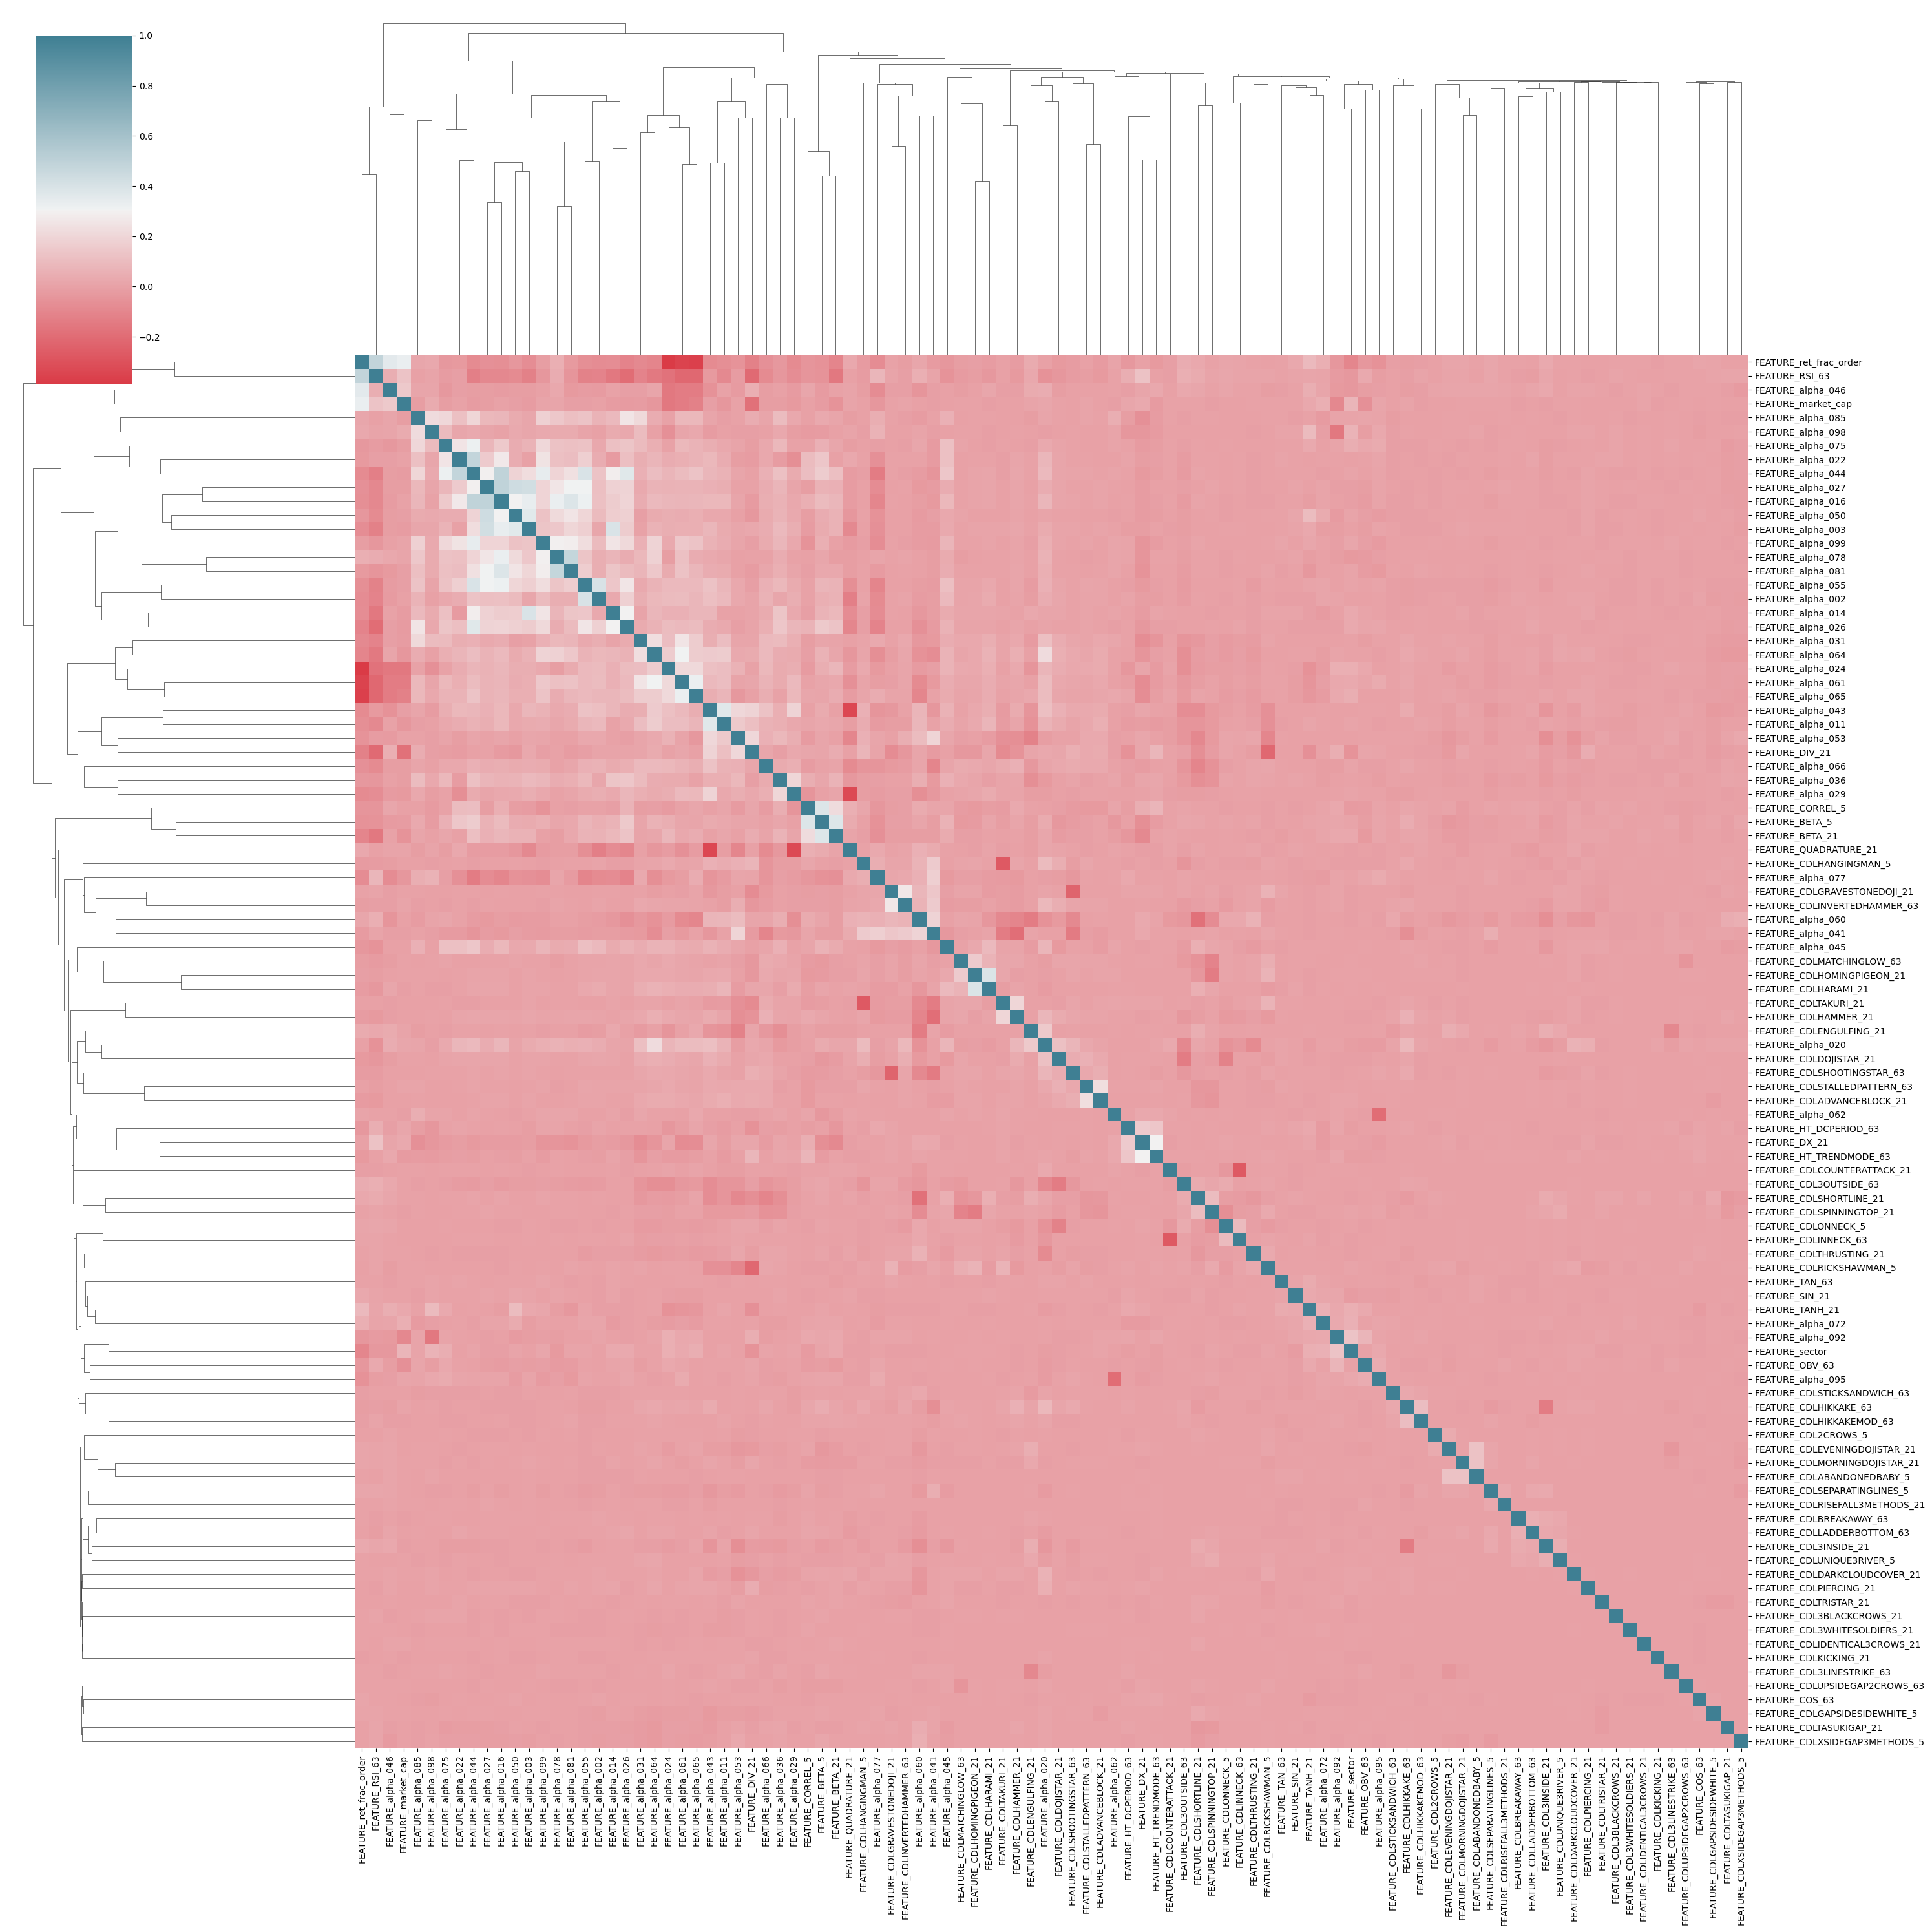

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns

# Assuming selected_corr_matrix is the variable containing your correlation matrix
# selected_corr_matrix = your_correlation_matrix_here

# Define the color map
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Create the clustermap
g = sns.clustermap(selected_corr_matrix, cmap=cmap, figsize=(30, 30))

plt.show()

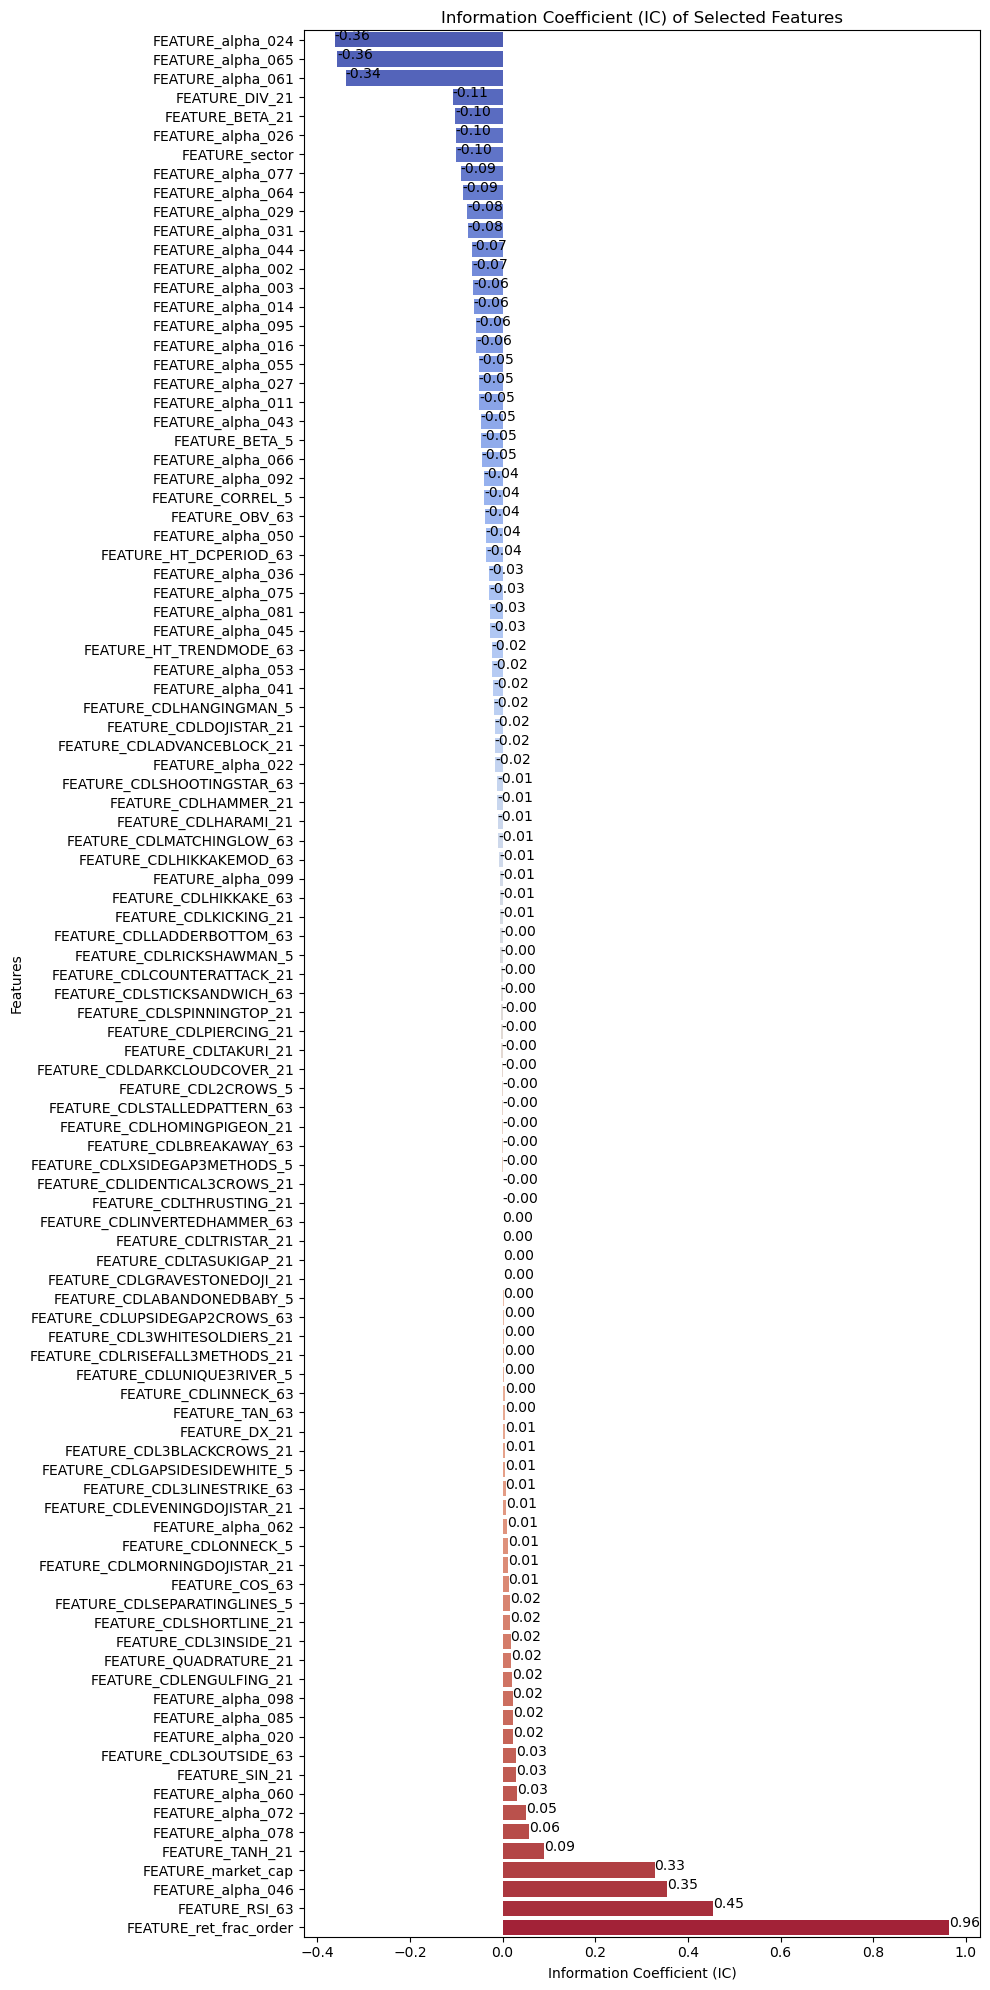

In [23]:
# Sort the Series for better visualization
sorted_ics = selected_ics.sort_values()

# Create the plot
plt.figure(figsize=(10, 20))  # Adjust the size as needed

sns.barplot(x=sorted_ics, y=sorted_ics.index, palette="coolwarm")

plt.xlabel('Information Coefficient (IC)')
plt.ylabel('Features')
plt.title('Information Coefficient (IC) of Selected Features')

# Annotate each bar with the actual IC value
for index, value in enumerate(sorted_ics):
    plt.text(value, index, f'{value:.2f}')

plt.tight_layout()

plt.show()

In [24]:
# import matplotlib.pyplot as plt

# def plot_time_series_cv_splits(dataframe, train_period_length=21*3, \
#     test_period_length=21, lookahead=1, date_idx='date'):
#     """
#     Plots the train and validation windows for time series cross-validation.
    
#     Parameters:
#         dataframe: The data to be split.
#         train_period_length: The number of business days in the training set.
#         test_period_length: The number of business days in the validation set.
#         lookahead: The gap between training and validation sets.
#         date_idx: The name of the date index in the dataframe.
#     """
    
#     cv_splits = CustomBackwardMultipleTimeSeriesCV(dataframe, \
#         train_period_length, test_period_length, lookahead, date_idx)
    
#     fig, ax = plt.subplots(figsize=(15, 5))
    
#     for i, (train_idx, test_idx) in enumerate(cv_splits):
#         # Get the date ranges
#         train_dates = dataframe.index.get_level_values(date_idx)[train_idx]
#         test_dates = dataframe.index.get_level_values(date_idx)[test_idx]

#         ax.plot([train_dates[0], train_dates[-1]], [i, i], color='blue', label='Training' if i == 0 else "")
#         ax.plot([test_dates[0], test_dates[-1]], [i, i], color='red', label='Validation' if i == 0 else "")
#         ax.scatter([train_dates[0], train_dates[-1]], [i, i], color='blue')
#         ax.scatter([test_dates[0], test_dates[-1]], [i, i], color='red')
        
#         # Draw vertical dashed lines to represent the lookahead gap for every split
#         gap_start = train_dates[-1]
#         gap_end = test_dates[0]
#         ax.axvline(x=gap_start, color='green', linestyle='--', alpha=0.6)
#         ax.axvline(x=gap_end, color='green', linestyle='--', alpha=0.6)

#         # Shade the lookahead gap
#         ax.axvspan(gap_start, gap_end, facecolor='gray', alpha=0.2)
        
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Iteration')
#     ax.set_title('Backward-Rolling Time Series CV Splits with Lookahead Gap')
#     ax.legend(loc='best')
#     plt.gca().invert_yaxis()  # invert y-axis to have the most recent data at the top
#     plt.show()

# # Now call the function to plot
# plot_time_series_cv_splits(reduced_dataframe)